In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
import scipy.stats as stats

from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
from bluecast.preprocessing.custom import CustomPreprocessing
from bluecast.general_utils.general_utils import save_to_production, load_for_production

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer, LabelEncoder

sns.set_style('darkgrid')
pyo.init_notebook_mode()
%matplotlib inline


plt.rc('figure',figsize=(18,11))
sns.set_context('notebook',font_scale=1)

import warnings
warnings.filterwarnings('ignore')

In [2]:
ob_data = pd.read_csv('ObesityDataSet.csv')
ob_data.head(10)

Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   
5    Male  29.0    1.62    53.0                             no  yes   2.0   
6  Female  23.0    1.50    55.0                            yes  yes   3.0   
7    Male  22.0    1.64    53.0                             no   no   2.0   
8    Male  24.0    1.78    64.0                            yes  yes   3.0   
9    Male  22.0    1.72    68.0                            yes  yes   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   
5  3.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   
6  3.0  Sometimes    no   2.0   no  1.0  0.0   Sometimes   
7  3.0  Sometimes    no   2.0   no  3.0  0.0   Sometimes   
8  3.0  Sometimes    no   2.0   no  1.0  1.0  Frequently   
9  3.0  Sometimes    no   2.0   no  1.0  1.0          no   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Transportation        Normal_Weight  
3                Walking   Overweight_Level_I  
4  Public_Transportation  Overweight_Level_II  
5             Automobile        Normal_Weight  
6              Motorbike        Normal_Weight  
7  Public_Transportation        Normal_Weight  
8  Public_Transportation        Normal_Weight  
9  Public_Transportation        Normal_Weight

In [3]:
ob_data.shape

(2111, 17)

In [4]:
ob_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

* **apprently no missing values in the dataset**

In [5]:
duplicates = sum(ob_data.duplicated())
duplicates

24

* **there are 24 duplicate observations**

# Initial Preprocessing

In [6]:
# get a copy of the dataframe
df = ob_data.copy()
df.shape

(2111, 17)

In [7]:
# remove duplicates
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
df.shape

(2087, 18)

In [8]:
df['NCP'].value_counts()

NCP
3.000000    1199
1.000000     179
4.000000      69
2.776840       2
3.985442       2
            ... 
3.054899       1
3.118013       1
3.335876       1
3.205009       1
1.089048       1
Name: count, Length: 635, dtype: int64

In [9]:
# rounding the values to make NCP categorical
df['NCP'] = np.round(df['NCP'])
df['NCP'] = df['NCP'].astype('int')
df['NCP'] = df['NCP'].astype('str')
df['NCP'].value_counts()

NCP
3    1466
1     296
2     176
4     149
Name: count, dtype: int64

In [10]:
# create BMI variable using Height and Weight variables
df['BMI'] = df['Weight'] / (df['Height']) ** 2
df.head()

index  Gender   Age  Height  Weight family_history_with_overweight FAVC  \
0      0  Female  21.0    1.62    64.0                            yes   no   
1      1  Female  21.0    1.52    56.0                            yes   no   
2      2    Male  23.0    1.80    77.0                            yes   no   
3      3    Male  27.0    1.80    87.0                             no   no   
4      4    Male  22.0    1.78    89.8                             no   no   

   FCVC NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0   2.0   3  Sometimes    no   2.0   no  0.0  1.0          no   
1   3.0   3  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2   2.0   3  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3   3.0   3  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4   2.0   1  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad        BMI  
0  Public_Transportation        Normal_Weight  24.386526  
1  Public_Transportation        Normal_Weight  24.238227  
2  Public_Transportation        Normal_Weight  23.765432  
3                Walking   Overweight_Level_I  26.851852  
4  Public_Transportation  Overweight_Level_II  28.342381

In [11]:
df.drop(['Height', 'Weight', 'index'], axis=1, inplace=True)
df.head()

Gender   Age family_history_with_overweight FAVC  FCVC NCP       CAEC  \
0  Female  21.0                            yes   no   2.0   3  Sometimes   
1  Female  21.0                            yes   no   3.0   3  Sometimes   
2    Male  23.0                            yes   no   2.0   3  Sometimes   
3    Male  27.0                             no   no   3.0   3  Sometimes   
4    Male  22.0                             no   no   2.0   1  Sometimes   

  SMOKE  CH2O  SCC  FAF  TUE        CALC                 MTRANS  \
0    no   2.0   no  0.0  1.0          no  Public_Transportation   
1   yes   3.0  yes  3.0  0.0   Sometimes  Public_Transportation   
2    no   2.0   no  2.0  1.0  Frequently  Public_Transportation   
3    no   2.0   no  2.0  0.0  Frequently                Walking   
4    no   2.0   no  0.0  0.0   Sometimes  Public_Transportation   

            NObeyesdad        BMI  
0        Normal_Weight  24.386526  
1        Normal_Weight  24.238227  
2        Normal_Weight  23.765432  
3   Overweight_Level_I  26.851852  
4  Overweight_Level_II  28.342381

In [12]:
# making the overweight levels one according to WHO
df['NObeyesdad'] = df['NObeyesdad'].replace({'Overweight_Level_I': 'Overweight', 'Overweight_Level_II': 'Overweight'})
df.head(10)

Gender   Age family_history_with_overweight FAVC  FCVC NCP       CAEC  \
0  Female  21.0                            yes   no   2.0   3  Sometimes   
1  Female  21.0                            yes   no   3.0   3  Sometimes   
2    Male  23.0                            yes   no   2.0   3  Sometimes   
3    Male  27.0                             no   no   3.0   3  Sometimes   
4    Male  22.0                             no   no   2.0   1  Sometimes   
5    Male  29.0                             no  yes   2.0   3  Sometimes   
6  Female  23.0                            yes  yes   3.0   3  Sometimes   
7    Male  22.0                             no   no   2.0   3  Sometimes   
8    Male  24.0                            yes  yes   3.0   3  Sometimes   
9    Male  22.0                            yes  yes   2.0   3  Sometimes   

  SMOKE  CH2O  SCC  FAF  TUE        CALC                 MTRANS  \
0    no   2.0   no  0.0  1.0          no  Public_Transportation   
1   yes   3.0  yes  3.0  0.0   Sometimes  Public_Transportation   
2    no   2.0   no  2.0  1.0  Frequently  Public_Transportation   
3    no   2.0   no  2.0  0.0  Frequently                Walking   
4    no   2.0   no  0.0  0.0   Sometimes  Public_Transportation   
5    no   2.0   no  0.0  0.0   Sometimes             Automobile   
6    no   2.0   no  1.0  0.0   Sometimes              Motorbike   
7    no   2.0   no  3.0  0.0   Sometimes  Public_Transportation   
8    no   2.0   no  1.0  1.0  Frequently  Public_Transportation   
9    no   2.0   no  1.0  1.0          no  Public_Transportation   

      NObeyesdad        BMI  
0  Normal_Weight  24.386526  
1  Normal_Weight  24.238227  
2  Normal_Weight  23.765432  
3     Overweight  26.851852  
4     Overweight  28.342381  
5  Normal_Weight  20.195092  
6  Normal_Weight  24.444444  
7  Normal_Weight  19.705532  
8  Normal_Weight  20.199470  
9  Normal_Weight  22.985398

In [13]:
# classify according to WHO conditions
df['WHO_ObClass'] = [0 for i in range(len(df))]
for i in range(len(df)):
    val = round(df['BMI'][i], 1)
    if  val < 18.5:
        df['WHO_ObClass'][i] = 'Insufficient_Weight'
    elif val >= 18.5 and val < 25:
        df['WHO_ObClass'][i] = 'Normal_Weight'
    elif val >= 25 and val < 30:
        df['WHO_ObClass'][i] = 'Overweight'
    elif val >= 30 and val < 35:
        df['WHO_ObClass'][i] = 'Obesity_Type_I'
    elif val >= 35 and val < 40:
        df['WHO_ObClass'][i] = 'Obesity_Type_II'
    elif val >= 40:
        df['WHO_ObClass'][i] = 'Obesity_Type_III'

df.head()

Gender   Age family_history_with_overweight FAVC  FCVC NCP       CAEC  \
0  Female  21.0                            yes   no   2.0   3  Sometimes   
1  Female  21.0                            yes   no   3.0   3  Sometimes   
2    Male  23.0                            yes   no   2.0   3  Sometimes   
3    Male  27.0                             no   no   3.0   3  Sometimes   
4    Male  22.0                             no   no   2.0   1  Sometimes   

  SMOKE  CH2O  SCC  FAF  TUE        CALC                 MTRANS  \
0    no   2.0   no  0.0  1.0          no  Public_Transportation   
1   yes   3.0  yes  3.0  0.0   Sometimes  Public_Transportation   
2    no   2.0   no  2.0  1.0  Frequently  Public_Transportation   
3    no   2.0   no  2.0  0.0  Frequently                Walking   
4    no   2.0   no  0.0  0.0   Sometimes  Public_Transportation   

      NObeyesdad        BMI    WHO_ObClass  
0  Normal_Weight  24.386526  Normal_Weight  
1  Normal_Weight  24.238227  Normal_Weight  
2  Normal_Weight  23.765432  Normal_Weight  
3     Overweight  26.851852     Overweight  
4     Overweight  28.342381     Overweight

In [14]:
df['WHO_ObClass'].value_counts()

WHO_ObClass
Overweight             552
Obesity_Type_I         369
Obesity_Type_II        338
Normal_Weight          299
Obesity_Type_III       268
Insufficient_Weight    261
Name: count, dtype: int64

In [15]:
# misclassifications according to WHO
sum(df['WHO_ObClass'] != df['NObeyesdad'])

99

In [16]:
# drop the original NObeyesdad variable as it contains misclassified data
# drop BMI column as it will be not using for the classification
df.drop(['NObeyesdad', 'BMI'], axis=1, inplace=True)
df.head()

Gender   Age family_history_with_overweight FAVC  FCVC NCP       CAEC  \
0  Female  21.0                            yes   no   2.0   3  Sometimes   
1  Female  21.0                            yes   no   3.0   3  Sometimes   
2    Male  23.0                            yes   no   2.0   3  Sometimes   
3    Male  27.0                             no   no   3.0   3  Sometimes   
4    Male  22.0                             no   no   2.0   1  Sometimes   

  SMOKE  CH2O  SCC  FAF  TUE        CALC                 MTRANS    WHO_ObClass  
0    no   2.0   no  0.0  1.0          no  Public_Transportation  Normal_Weight  
1   yes   3.0  yes  3.0  0.0   Sometimes  Public_Transportation  Normal_Weight  
2    no   2.0   no  2.0  1.0  Frequently  Public_Transportation  Normal_Weight  
3    no   2.0   no  2.0  0.0  Frequently                Walking     Overweight  
4    no   2.0   no  0.0  0.0   Sometimes  Public_Transportation     Overweight

In [17]:
# train test split before further analysis
from sklearn.model_selection import train_test_split

X = df.drop(['WHO_ObClass'], axis=1)
y = df['WHO_ObClass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

df_train = pd.concat([X_train, pd.DataFrame(y_train)], join='inner', axis=1)
df_train.head()

Gender        Age family_history_with_overweight FAVC      FCVC NCP  \
1760    Male  23.319635                            yes  yes  3.000000   3   
1530    Male  21.963787                            yes  yes  3.000000   2   
935   Female  16.370009                            yes  yes  2.206399   1   
515   Female  19.869970                             no  yes  3.000000   1   
1138  Female  41.743333                            yes  yes  2.733129   3   

            CAEC SMOKE      CH2O  SCC       FAF       TUE       CALC  \
1760   Sometimes    no  2.628816   no  0.975384  0.000000  Sometimes   
1530   Sometimes    no  1.340117   no  0.428259  0.000000  Sometimes   
935    Sometimes    no  2.000000  yes  0.948930  1.772463         no   
515   Frequently    no  1.527036   no  0.000000  0.860497  Sometimes   
1138   Sometimes    no  1.302594   no  0.000000  1.103349         no   

                     MTRANS          WHO_ObClass  
1760  Public_Transportation      Obesity_Type_II  
1530  Public_Transportation      Obesity_Type_II  
935   Public_Transportation           Overweight  
515   Public_Transportation  Insufficient_Weight  
1138             Automobile           Overweight

# Initial Data Analysis

In [18]:
response = "WHO_ObClass"

# customized function to do the label encoding
def myLabelEncoder(dict, res=response, df=df):
    df[response] = df[response].replace(dict)
    
label_dict = {'Insufficient_Weight':0, 'Normal_Weight':1, 'Overweight':2, 'Obesity_Type_I':3, 'Obesity_Type_II':4, 'Obesity_Type_III':5}

In [19]:
# response groups 
df_train[response].value_counts()

WHO_ObClass
Overweight             442
Obesity_Type_I         295
Obesity_Type_II        270
Normal_Weight          239
Obesity_Type_III       214
Insufficient_Weight    209
Name: count, dtype: int64

In [20]:
# blucast for EDA
from bluecast.eda.analyse import (
    plot_pie_chart,
    plot_count_pairs,
    bi_variate_plots,
    correlation_heatmap,
    correlation_to_target,
    plot_pca,
    plot_pca_cumulative_variance,
    plot_theil_u_heatmap,
    plot_tsne,
    univariate_plots,
    check_unique_values,
    plot_null_percentage,
    mutual_info_to_target
)

from bluecast.preprocessing.feature_types import FeatureTypeDetector

In [21]:
# detect feature types
ignore_cols = []

f_type_detector = FeatureTypeDetector()
data = f_type_detector.fit_transform_feature_types(df_train.drop(ignore_cols, axis=1))

print("num_data", len(f_type_detector.num_columns))
print("cat_data", len(f_type_detector.cat_columns))

INFO:root:Start detecting and casting feature types.
INFO:root:Dropped the following columns as being Nulls only: [].
INFO:root:Dropped the following columns as being Nulls only: [].
INFO:root:Dropped the following columns as constants only: [].
INFO:root:Dropped the following columns as constants only: [].


num_data 5
cat_data 10


## univariate analysis

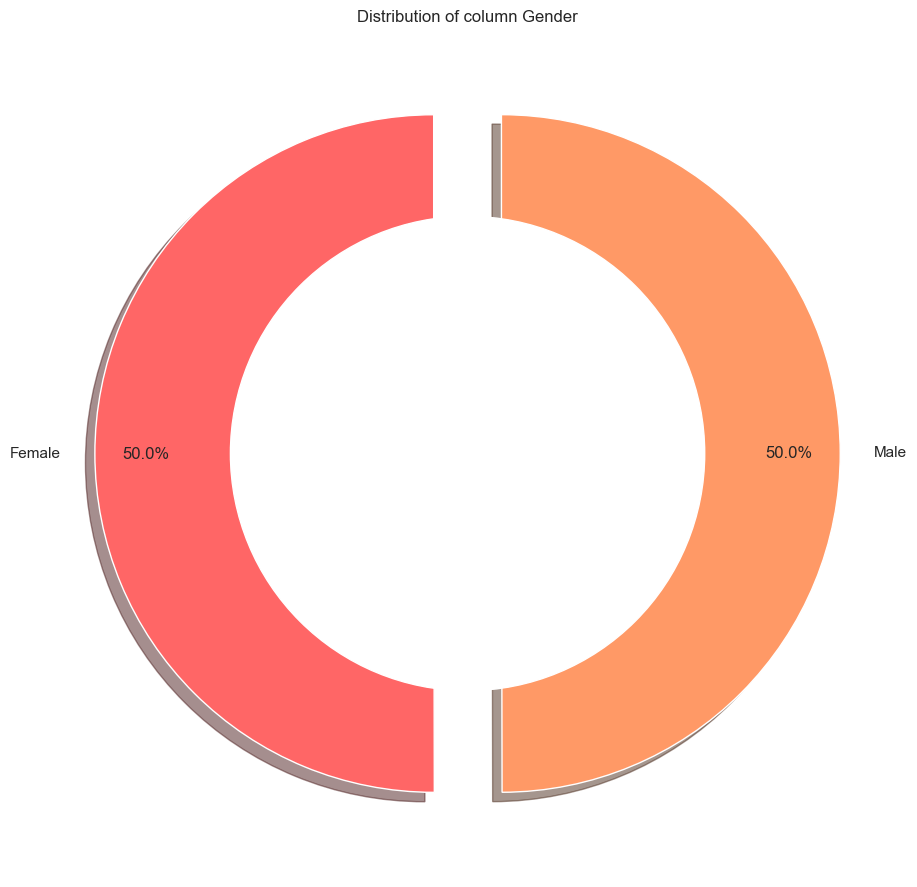

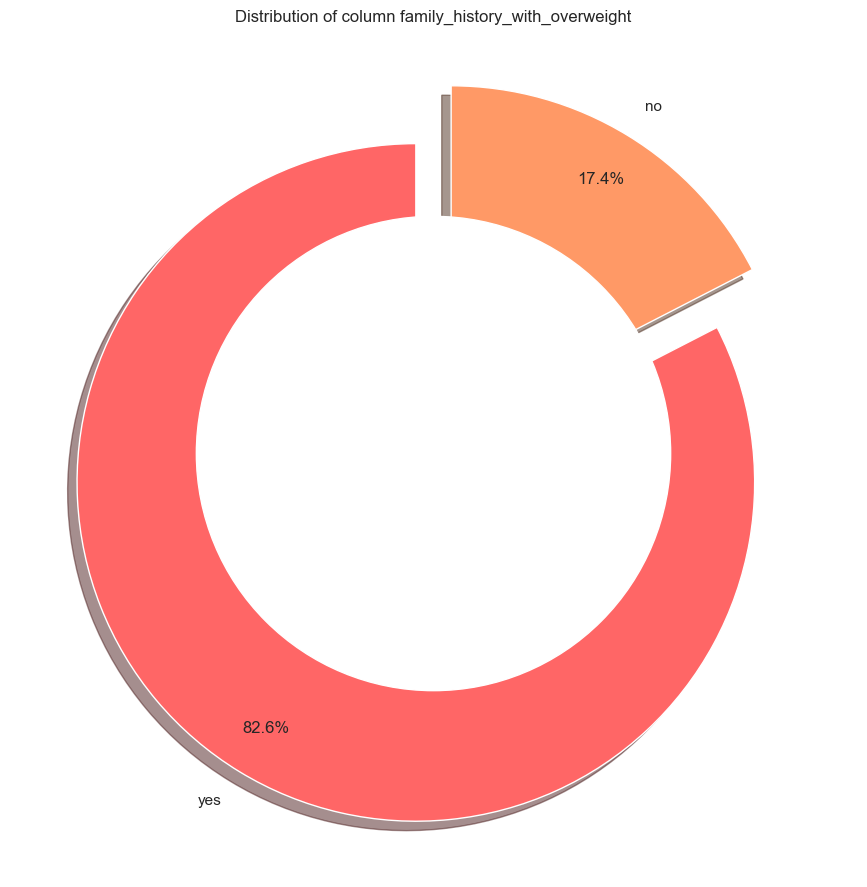

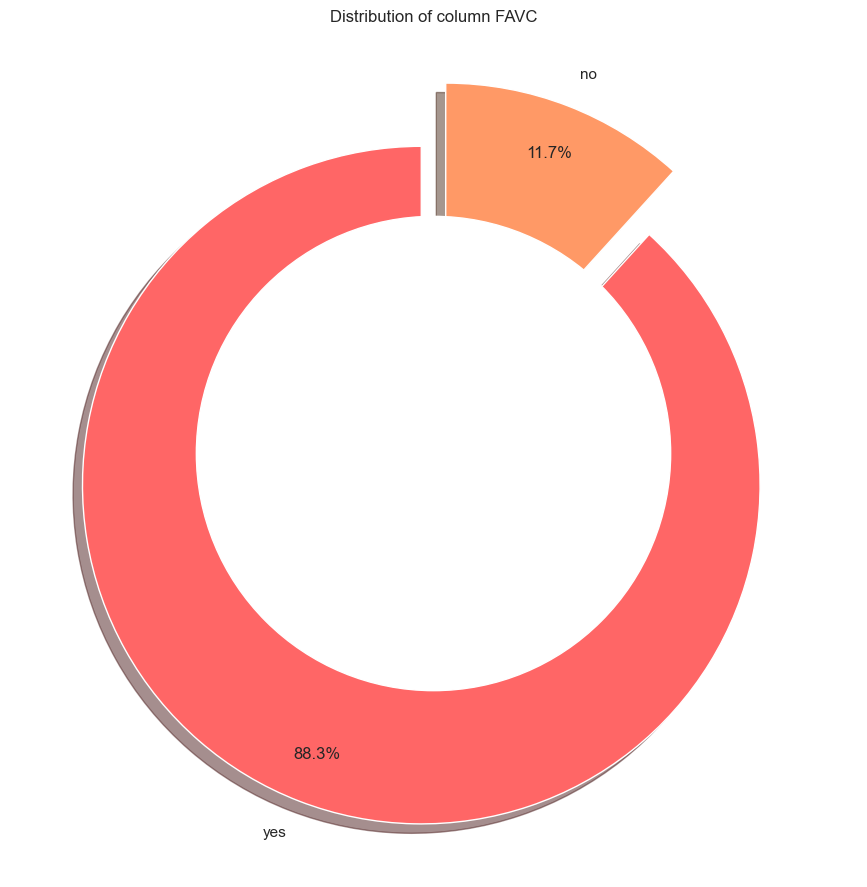

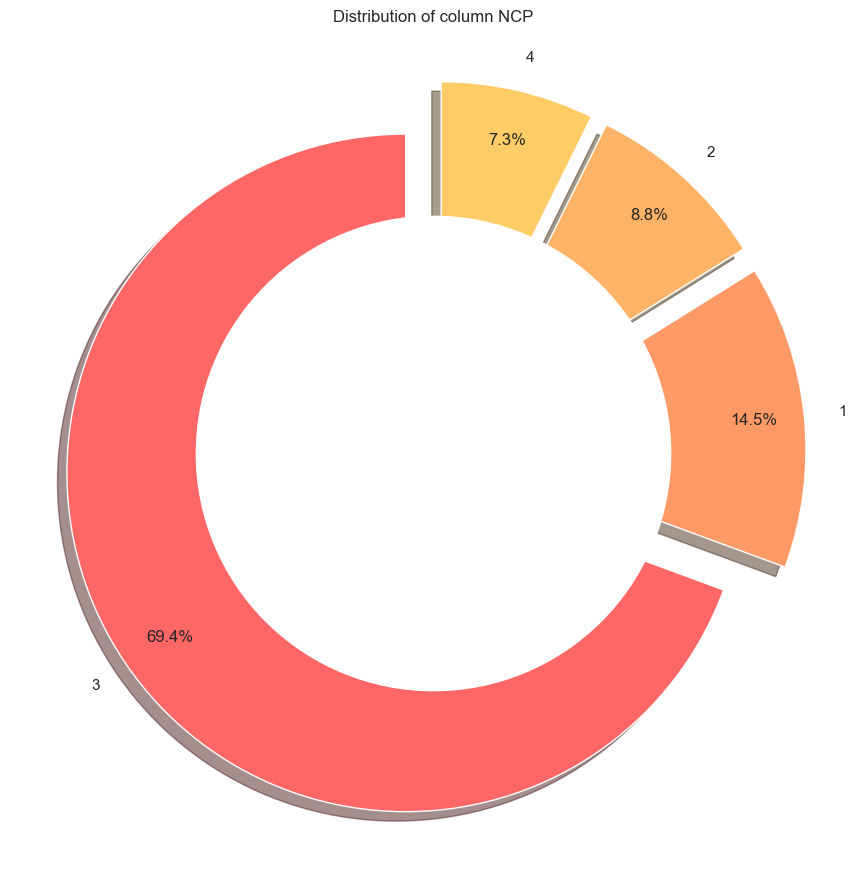

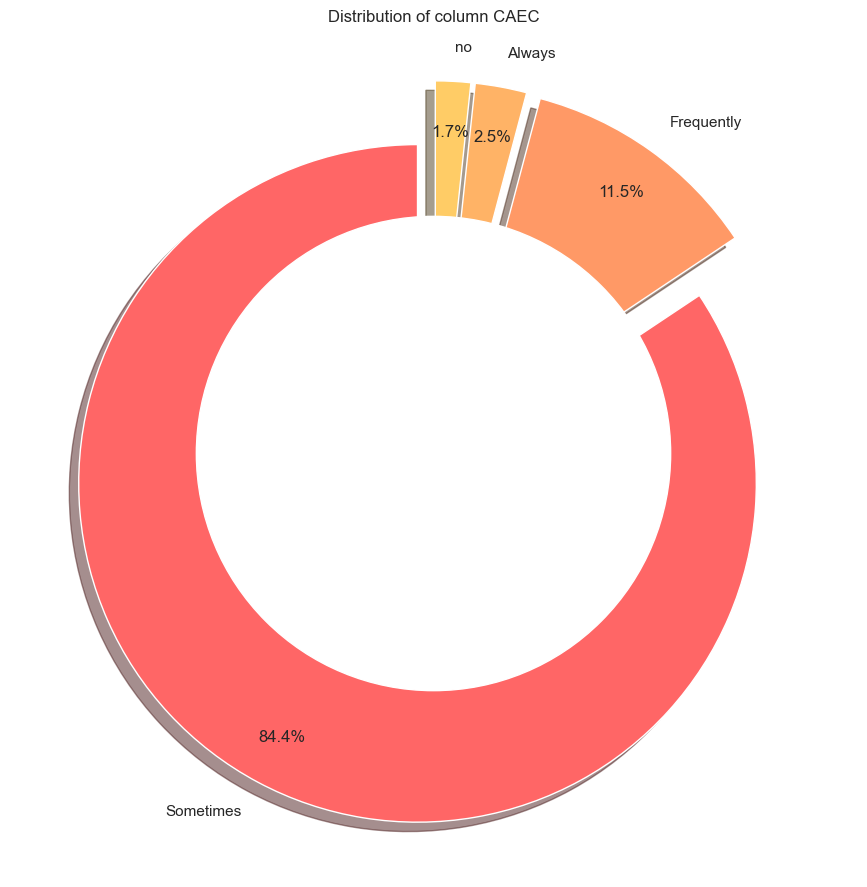

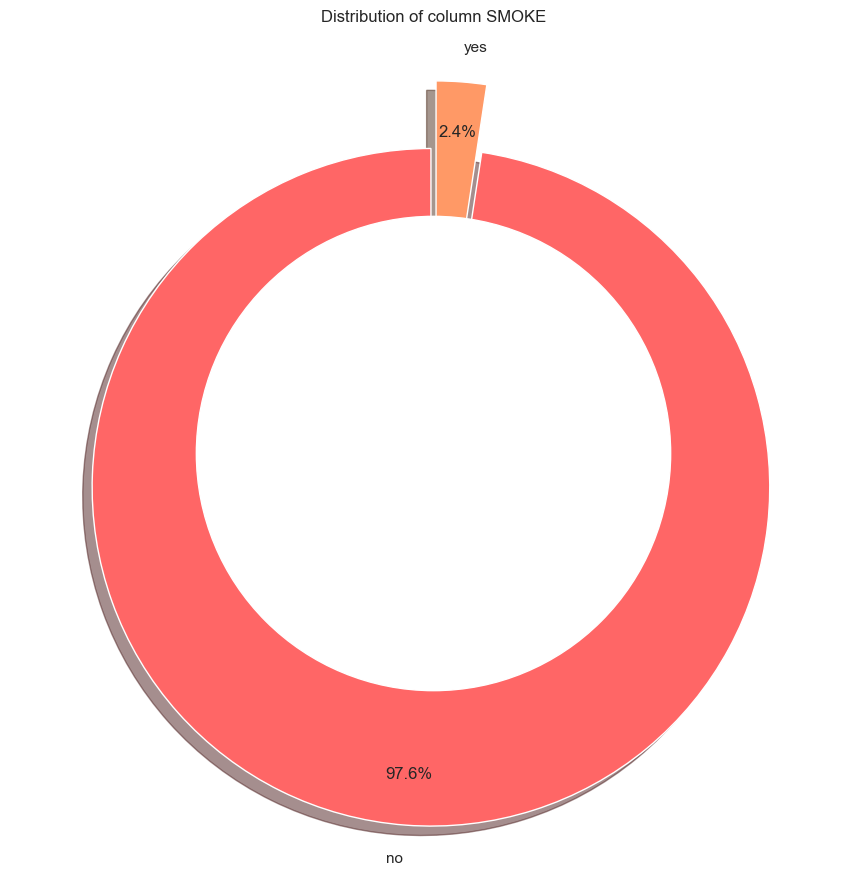

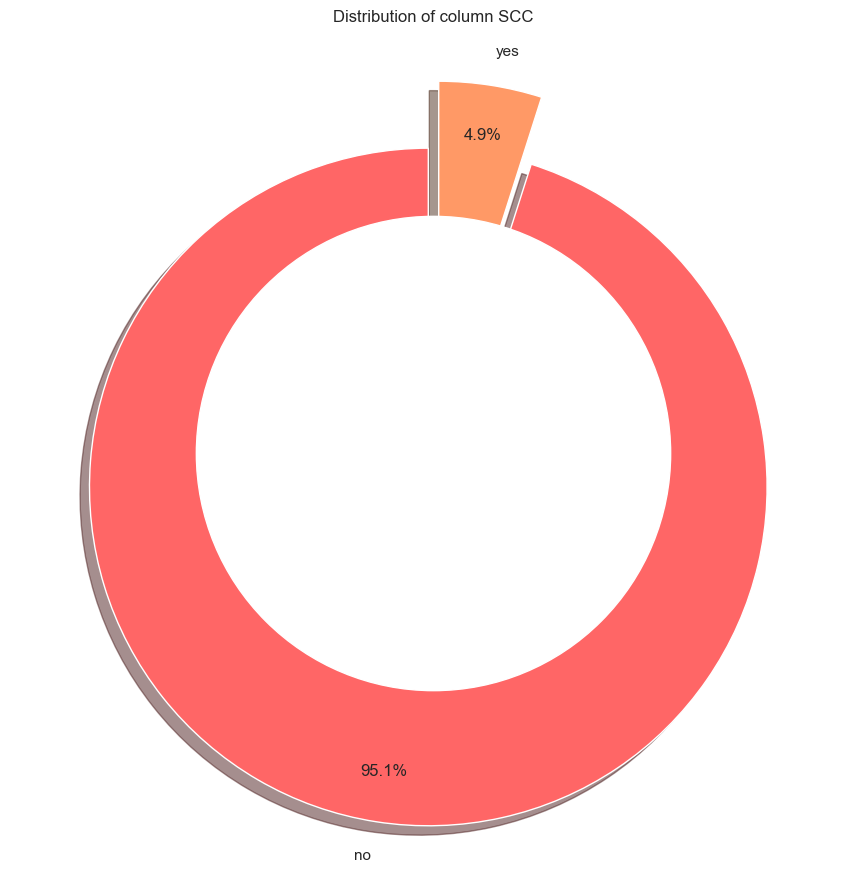

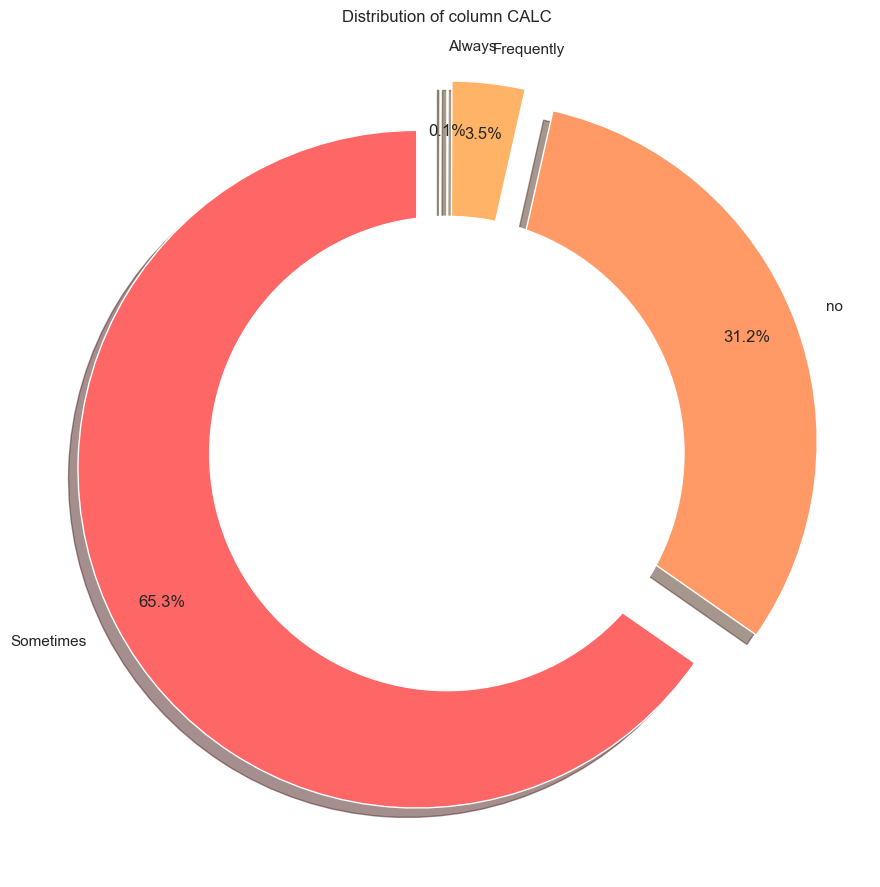

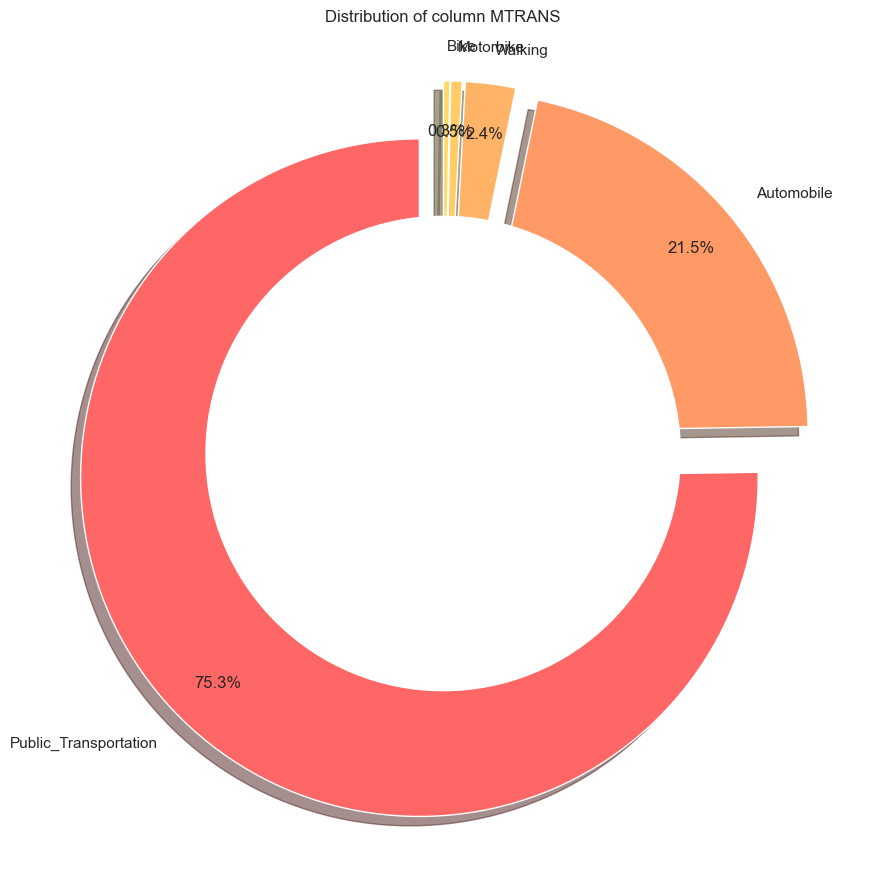

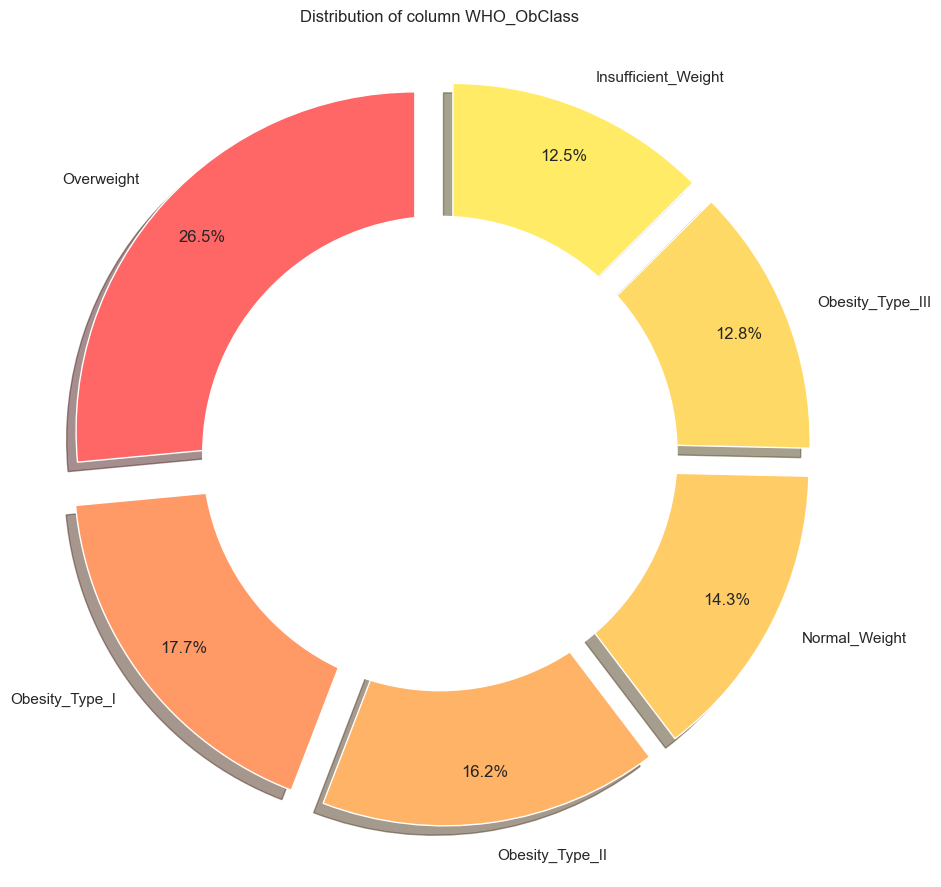

In [22]:
for col in f_type_detector.cat_columns:
    plot_pie_chart(
            data,
            col,
        )

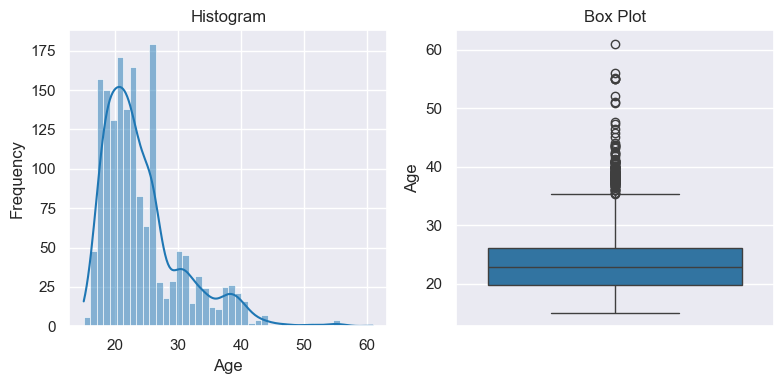

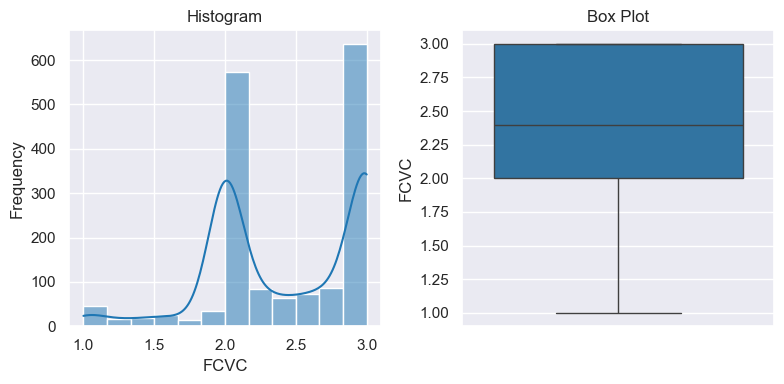

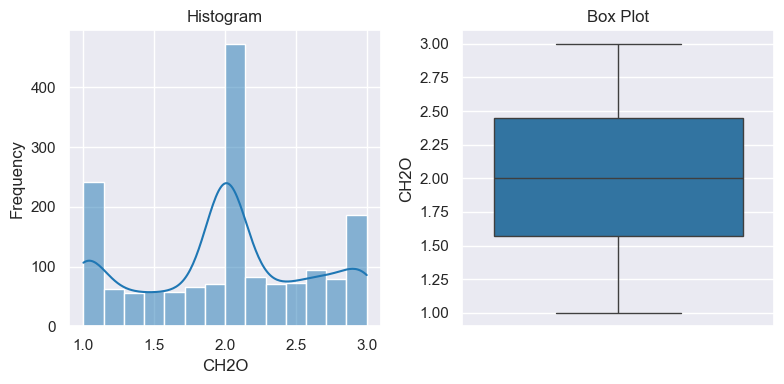

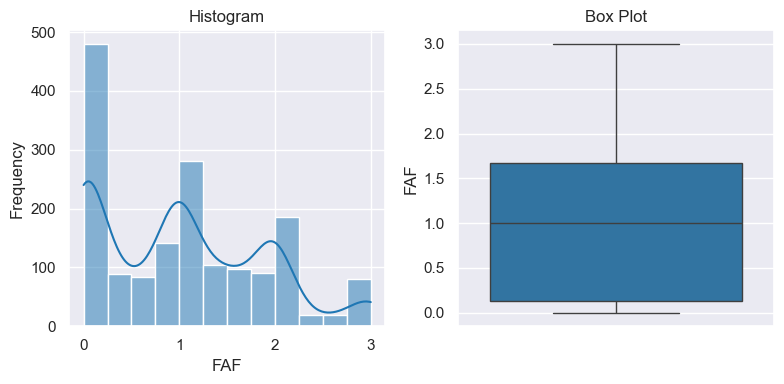

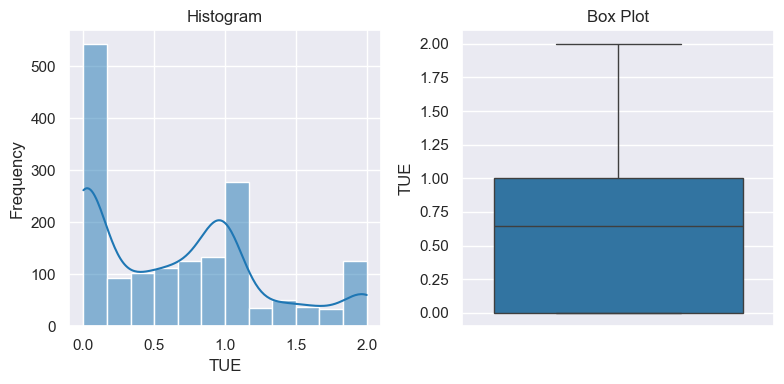

In [23]:
univariate_plots(
        data.loc[:, f_type_detector.num_columns]
    )

In [24]:
# detect columns with a very high share of unique values
many_unique_cols = check_unique_values(df, f_type_detector.cat_columns, threshold=0.5)
many_unique_cols

[]

## Bivariate analysis

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

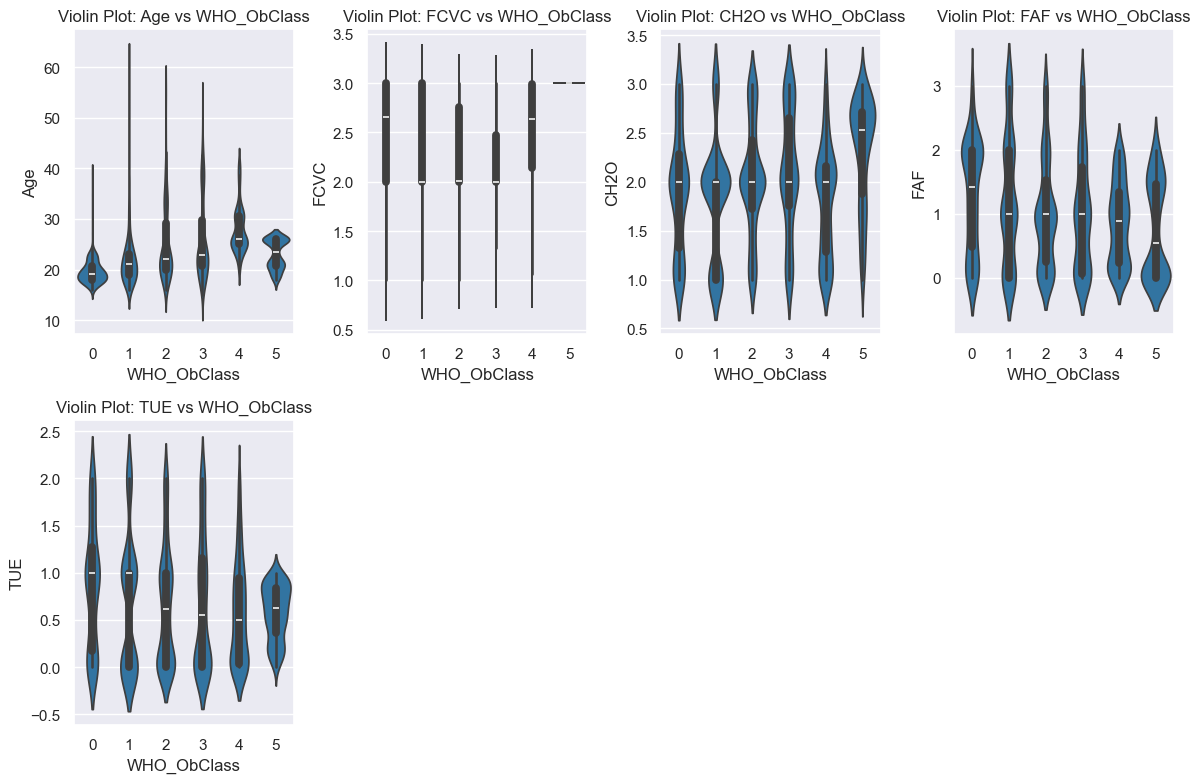

In [25]:
encoded_target_train = df_train.copy()
myLabelEncoder(dict=label_dict, res=response, df=encoded_target_train)

bi_variate_plots(
        encoded_target_train.loc[
            :, f_type_detector.num_columns + [response]
        ],
        response,
    )

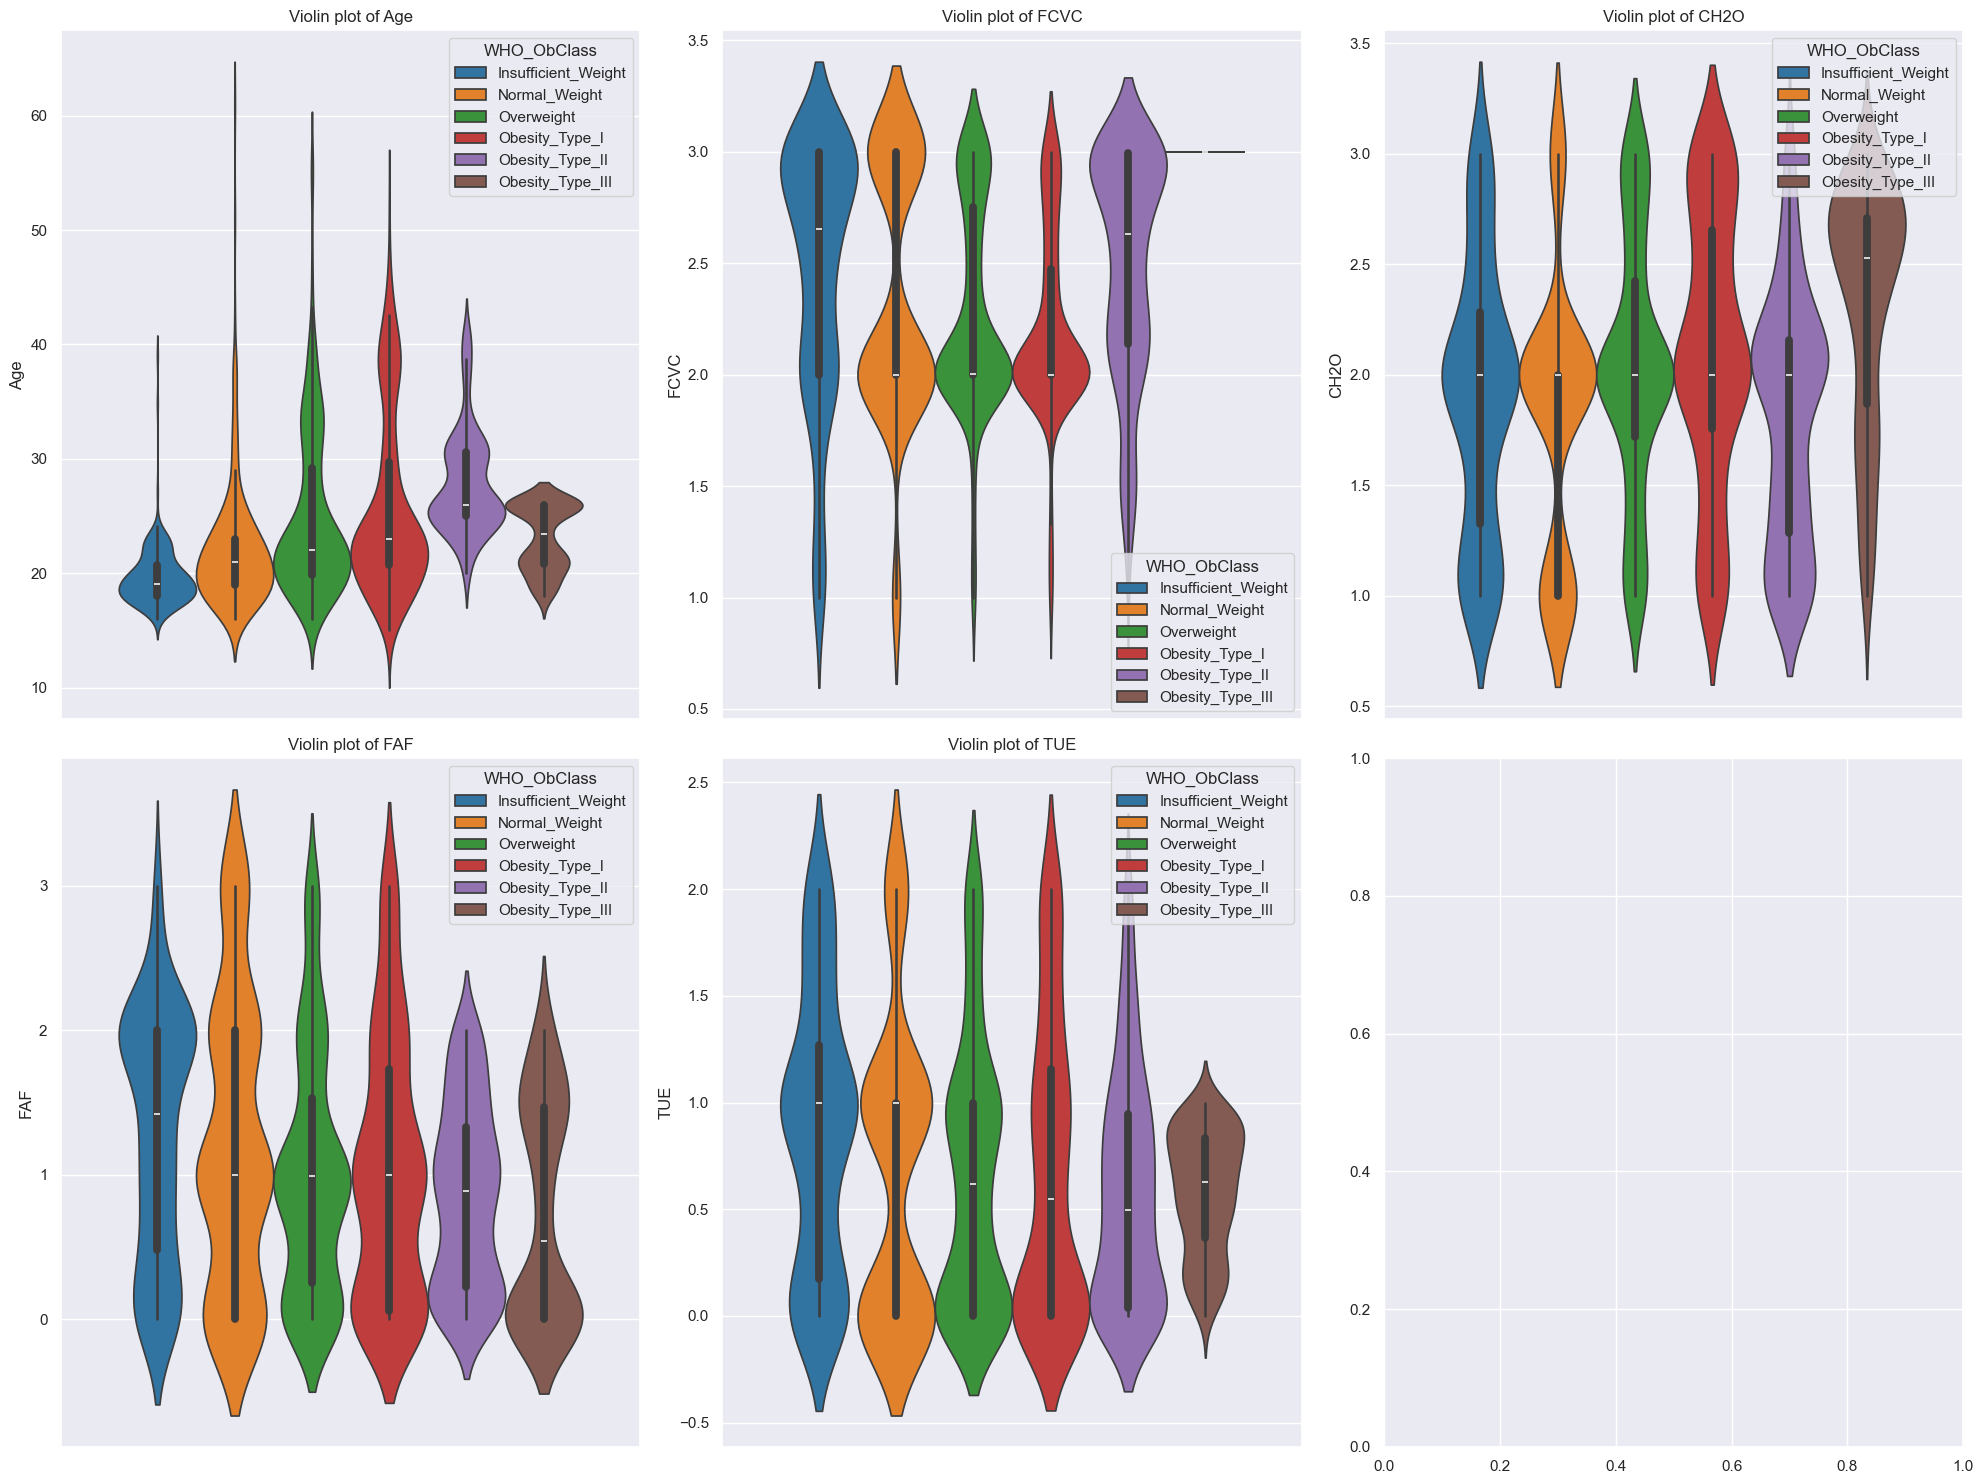

In [26]:
num_data = df_train.select_dtypes(include=['float'])

# Initialize the figure and the axes
fig, axes = plt.subplots(2, 3, figsize=(20, 15))

axes = axes.flatten()
hue_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

# Plot violin plots in each subplot
for idx, col in enumerate(num_data.columns):
    sns.violinplot(ax=axes[idx], y=num_data[col], hue=df_train['WHO_ObClass'], hue_order=hue_order)
    axes[idx].set_title(f'Violin plot of {col}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### correlation with the response

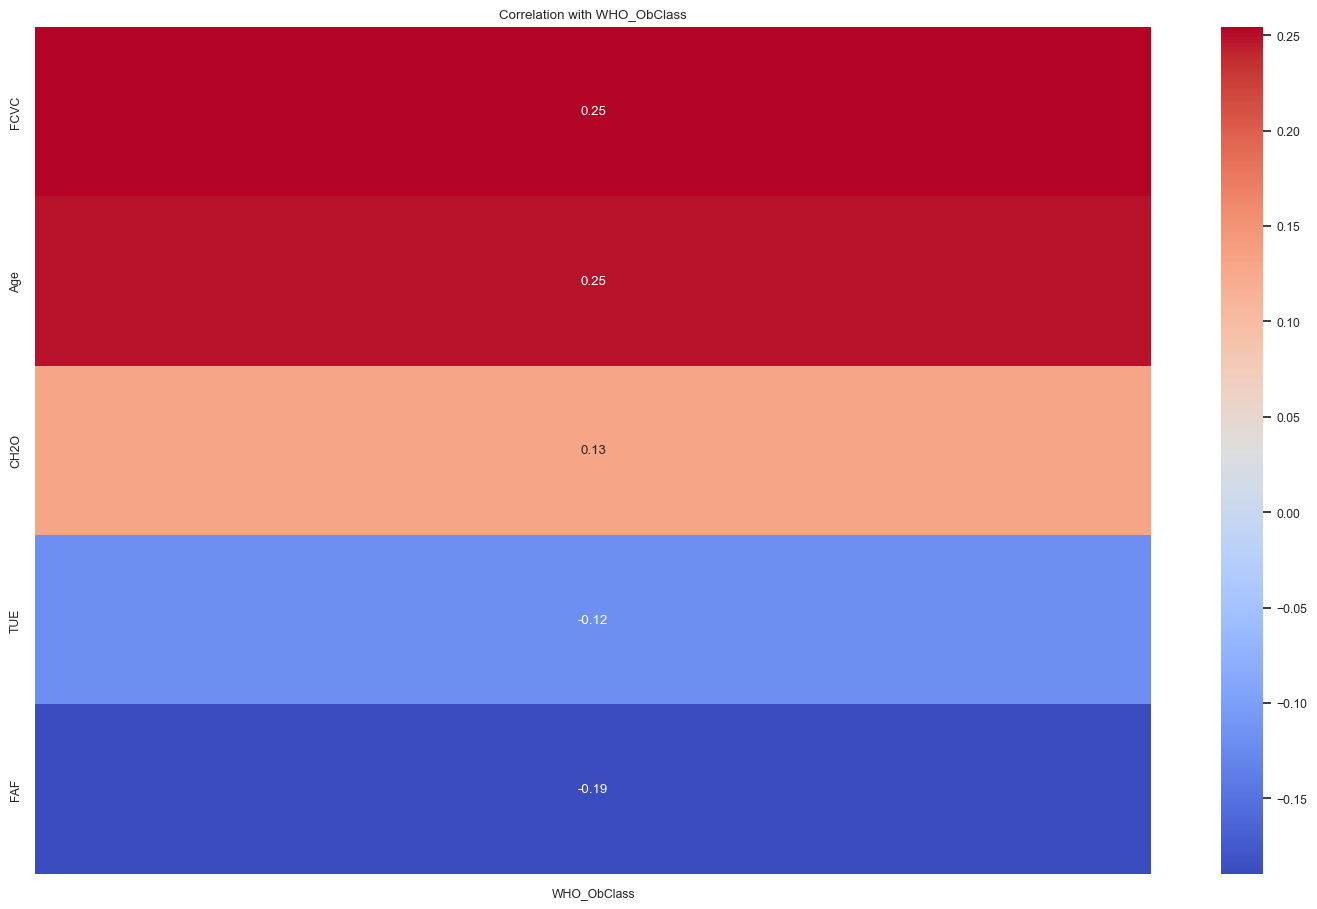

In [27]:
# show correlation to target
correlation_to_target(
    encoded_target_train.loc[:, f_type_detector.num_columns + [response]],
    response,
      )

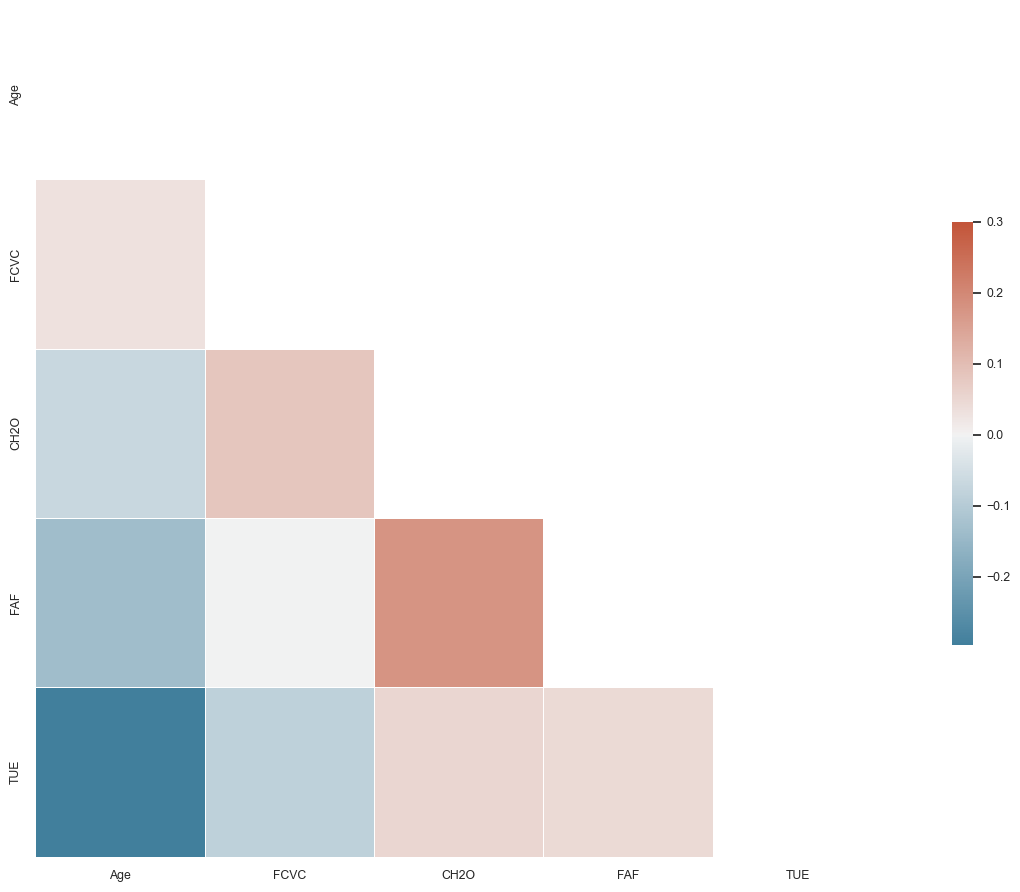

In [28]:
# correlation heatmap
correlation_heatmap(encoded_target_train.loc[
            :, f_type_detector.num_columns])

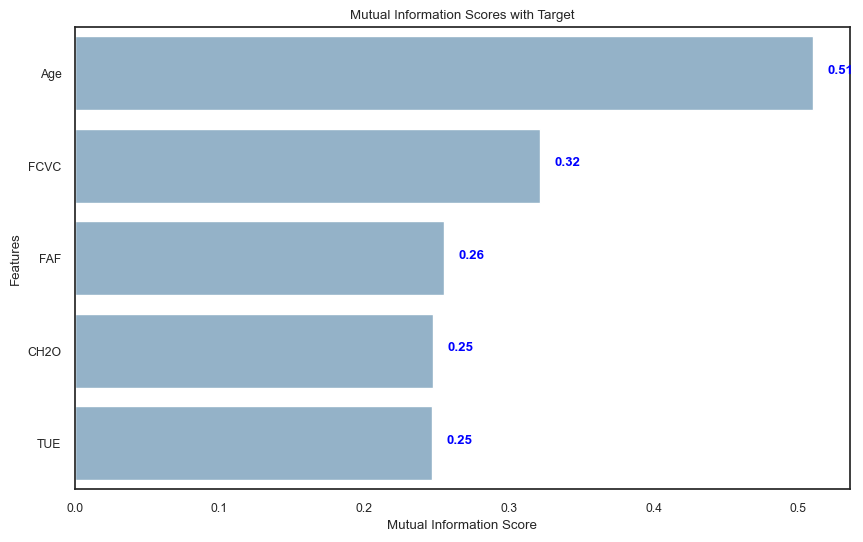

In [29]:
extra_params = {"random_state": 42}
mutual_info_to_target(encoded_target_train.loc[:, f_type_detector.num_columns + [response]], response, class_problem="multiclass", **extra_params)

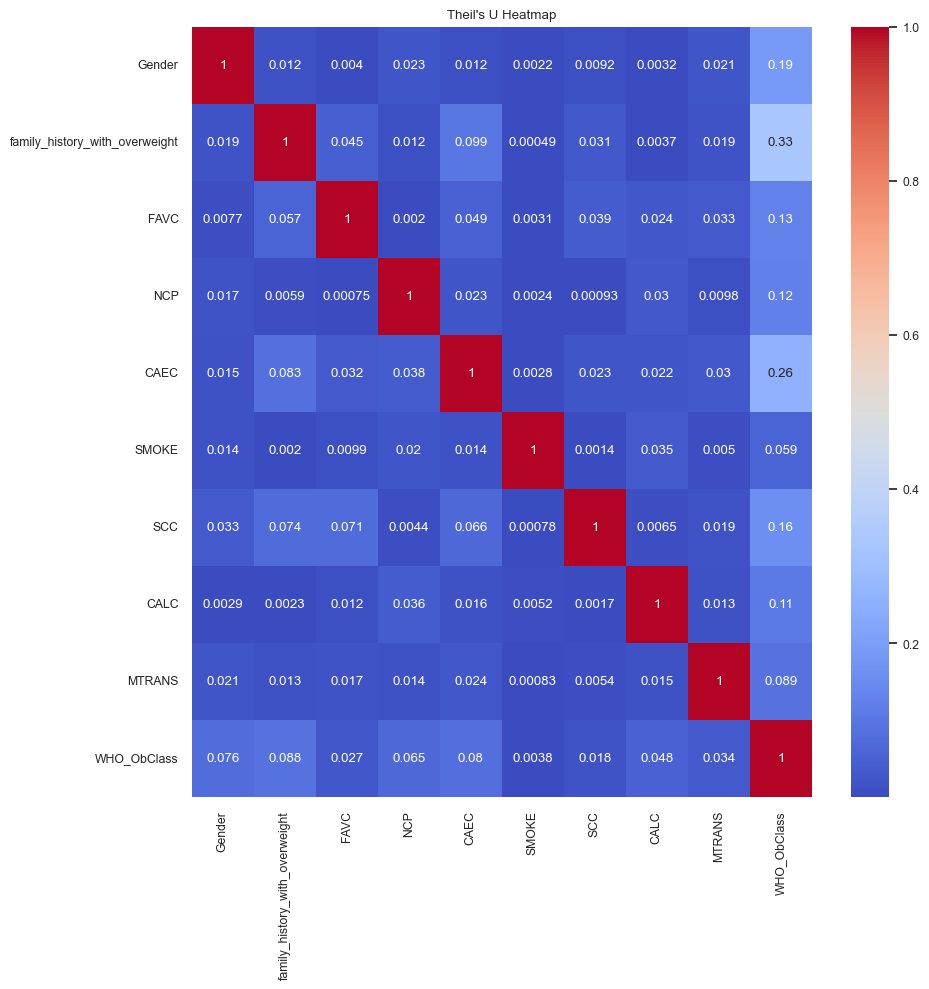

In [30]:
# theil's U 
# heat map of assocations between categorical variables
if len(f_type_detector.cat_columns) > 0:
    theil_matrix = plot_theil_u_heatmap(df_train, f_type_detector.cat_columns)
    theil_matrix

## Factor Analysis for Mixed data

In [31]:
import prince

# Initialize FAMD
famd = prince.FAMD(
    n_components=10,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn'
)

# Fit FAMD on the dataset
famd = famd.fit(df_train)

In [32]:
summary = famd.eigenvalues_summary
summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0             12.246        10.21%                     10.21%
1              9.148         7.62%                     17.83%
2              7.131         5.94%                     23.77%
3              6.736         5.61%                     29.38%
4              6.017         5.01%                     34.40%
5              5.754         4.80%                     39.19%
6              5.585         4.65%                     43.85%
7              5.429         4.52%                     48.37%
8              5.258         4.38%                     52.75%
9              4.930         4.11%                     56.86%

In [33]:
summary['% of variance'] = summary['% of variance'].replace({'%':''}, regex=True).astype('float')
summary

eigenvalue  % of variance % of variance (cumulative)
component                                                     
0             12.246          10.21                     10.21%
1              9.148           7.62                     17.83%
2              7.131           5.94                     23.77%
3              6.736           5.61                     29.38%
4              6.017           5.01                     34.40%
5              5.754           4.80                     39.19%
6              5.585           4.65                     43.85%
7              5.429           4.52                     48.37%
8              5.258           4.38                     52.75%
9              4.930           4.11                     56.86%

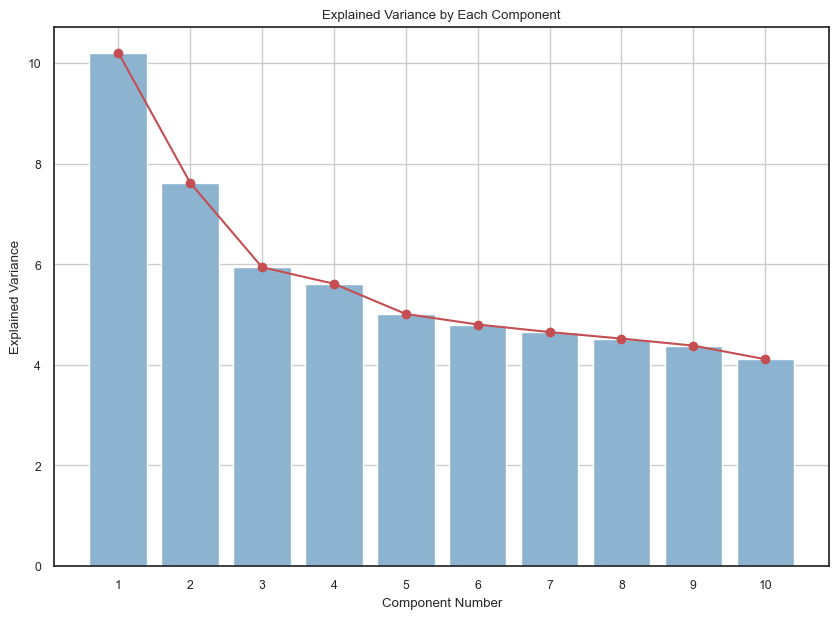

In [34]:
# Get the explained inertia (variance) for each component
# and generate the bar plot
plt.figure(figsize=(10, 7))
plt.bar(range(1, len(summary) + 1), summary['% of variance'])
plt.plot(range(1, len(summary) + 1), summary['% of variance'], 'ro')
plt.plot(range(1, len(summary) + 1), summary['% of variance'], 'r-')
plt.title('Explained Variance by Each Component')
plt.xlabel('Component Number')
plt.ylabel('Explained Variance')
plt.xticks(range(1, len(summary) + 1))
plt.grid(True)
plt.show()

## Multicollinearity

In [35]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

cat_data = df_train.select_dtypes(include=['object'])
num_data = df_train.select_dtypes(include=['float'])
X_train_copy = encoded_target_train.copy()
X_train_copy.drop(['WHO_ObClass'], axis=1, inplace=True)
cat_data.drop(['WHO_ObClass'], axis=1, inplace=True)
for col in cat_data.columns:
    X_train_copy[col] = LabelEncoder().fit_transform(X_train_copy[col])

for col in num_data.columns:
    X_train_copy[col] = MinMaxScaler().fit_transform(X_train_copy[[col]])

# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_copy.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_copy.values, i) for i in range(X_train_copy.shape[1])]

print(vif_data)

                           feature        VIF
0                           Gender   2.349544
1                              Age   4.695431
2   family_history_with_overweight   7.020121
3                             FAVC   8.776404
4                             FCVC   8.266044
5                              NCP   5.113429
6                             CAEC  15.979240
7                            SMOKE   1.065958
8                             CH2O   4.096083
9                              SCC   1.132616
10                             FAF   2.747262
11                             TUE   2.430303
12                            CALC  14.397180
13                          MTRANS   5.954358


## Clustering (KPrototype)

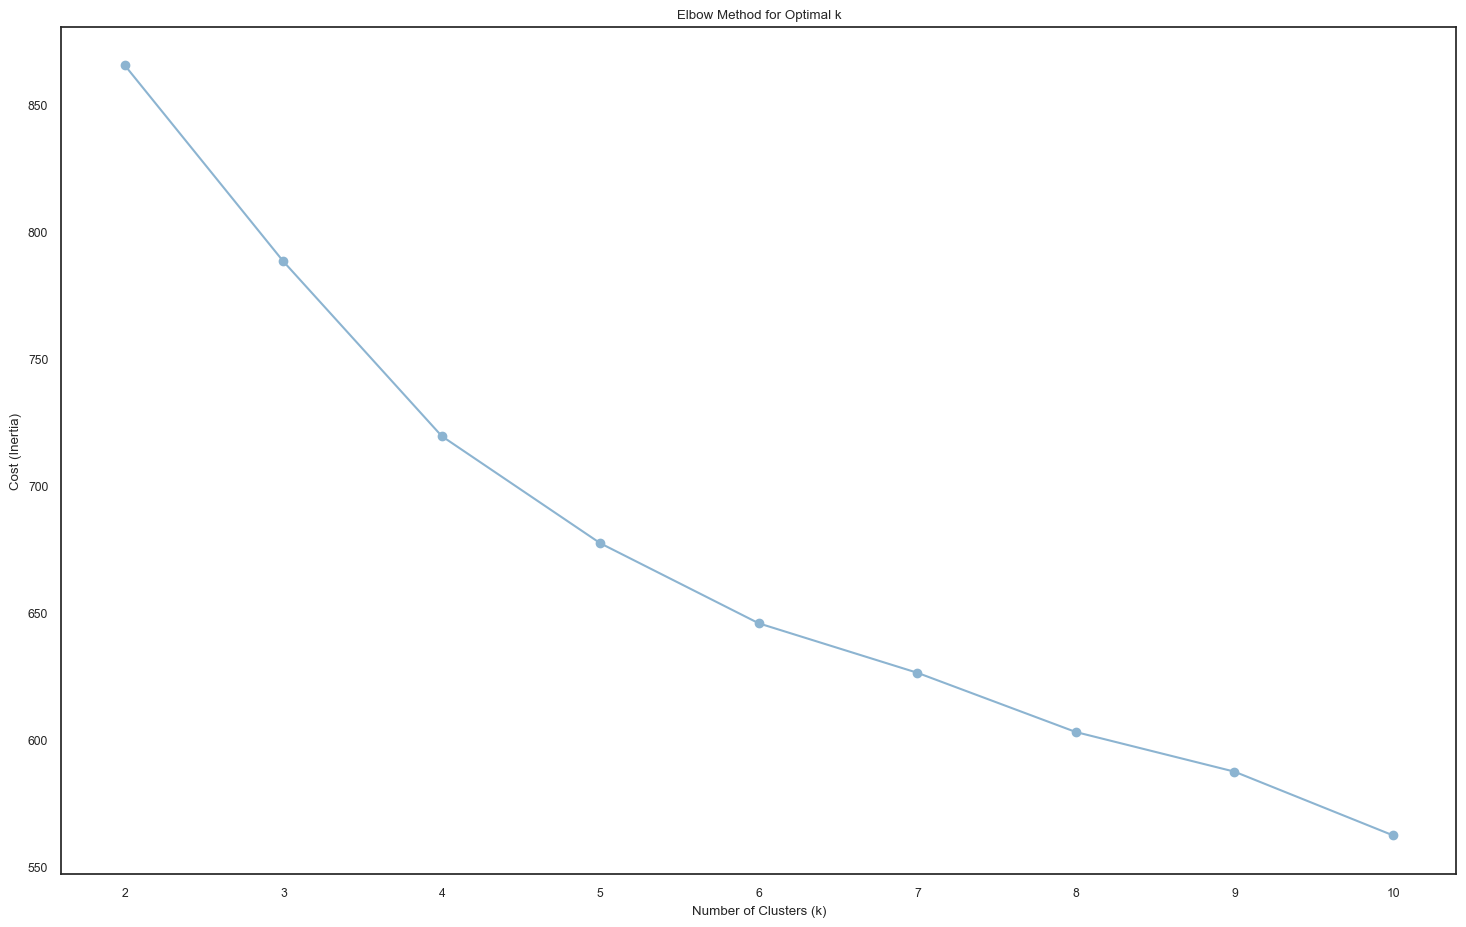

In [36]:
df_mat = X_train_copy.to_numpy()

# identify the optimal number of clusters using elbow graph
from kmodes.kprototypes import KPrototypes

# Specify the indices of the categorical features
categorical_indices = [0, 2, 3, 5, 6, 7, 9, 12, 13]
#categorical_cols = X_train.select_dtypes(include=['object']).columns
#numerical_cols = X_train.select_dtypes(include=['float']).columns
# Initialize an empty list to store the cost (inertia) for each k
costs = []

for k in range(2,11):
    kproto = KPrototypes(n_clusters=k, init='Cao', verbose=0)
    clusters = kproto.fit_predict(df_mat, categorical=categorical_indices)
    cost = kproto.cost_
    costs.append(cost)

# Plot the elbow graph
plt.plot(range(2,11), costs, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost (Inertia)')
plt.show()

In [37]:
# cost (sum distance): confirm visual clue of elbow plot
# KneeLocator class will detect elbows if curve is convex; if concave, will detect knees
from kneed import KneeLocator
cost_knee_c3 = KneeLocator(
        x=range(2,11), 
        y=costs, 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow   
print("elbow at k =", f'{K_cost_c3:.0f} clusters')

elbow at k = 5 clusters


* **looking at the graph, optimal number of clusters is 5**

In [38]:
# fitting 5 clusters
kproto = KPrototypes(n_clusters=5, init='Cao', verbose=0)
clusters = kproto.fit_predict(df_mat, categorical=categorical_indices)

In [39]:
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, silhouette_samples

# Separate numerical and categorical data
num_data = X_train_copy.select_dtypes(['float']).values
cat_data = X_train_copy.select_dtypes(['int']).values
cat_data = cat_data.astype('float')

# Calculate Euclidean distance for numerical data
euclidean_dist = cdist(num_data, num_data, metric='euclidean')

# Calculate matching distance for categorical data
matching_dist = cdist(cat_data, cat_data, metric='matching')

# Combine distances with weights
# Assuming equal weights for numerical and categorical distances
weight_num = 6
weight_cat = 8

combined_dist = weight_num * euclidean_dist + weight_cat * matching_dist

# getting the sillout score
s = silhouette_score(combined_dist, clusters, metric="precomputed")
print('silhouette score (k=5):', s)

silhouette score (k=5): 0.14471358763488612


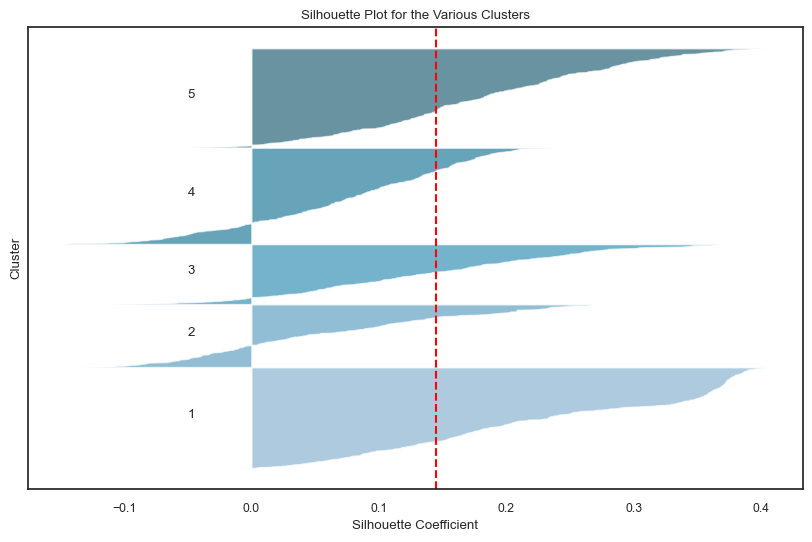

In [40]:
# Compute silhouette scores for each sample
silhouette_vals = silhouette_samples(combined_dist, clusters, metric="precomputed")

# Plot silhouette scores
fig, ax = plt.subplots(figsize=(10, 6))

y_lower, y_upper = 0, 0
for i in range(5):
    cluster_silhouette_vals = silhouette_vals[clusters == i]
    cluster_silhouette_vals.sort()

    y_upper += len(cluster_silhouette_vals)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(cluster_silhouette_vals), str(i + 1))

    y_lower = y_upper

ax.axvline(x=s, color="red", linestyle="--")
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_title('Silhouette Plot for the Various Clusters')
ax.set_yticks([])  # Clear the y-axis labels

plt.show()